In [1]:
#ResNet Practice, Data Augmentation
#https://www.youtube.com/watch?v=sJF6PiAjE1M&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa&index=5

import os
import torch
import torchvision
import torchvision.transforms as tt
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [2]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  #Mean and std. deviation of pixels
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfms)

print(testset.classes)

print("len(trainset): ", len(trainset), "len(testset): ", len(testset))



Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
len(trainset):  50000 len(testset):  10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


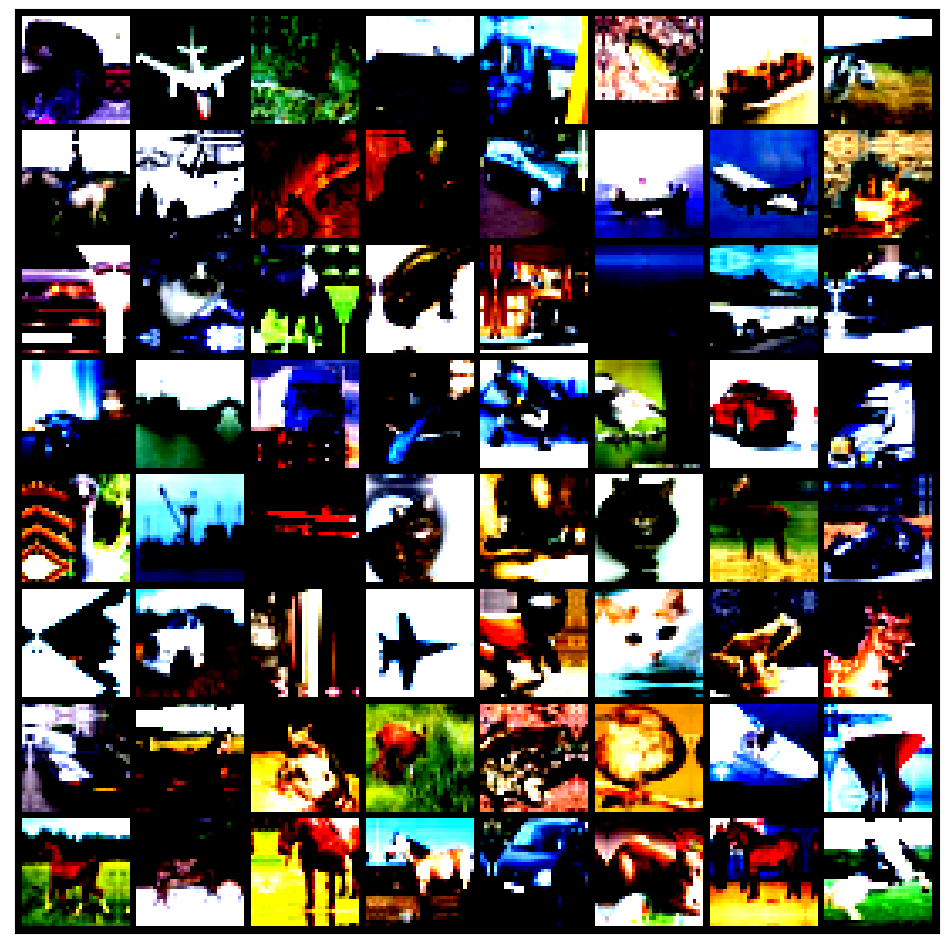

In [3]:
batch_size = 400

#Take test data as validation data, so that increase the data for training
train_dl = DataLoader(trainset, batch_size, shuffle = True, num_workers=3, pin_memory= True)
valid_dl = DataLoader(testset, batch_size*2, num_workers=3, pin_memory= True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break

show_batch(train_dl)

In [4]:
#Utilize GPU if there is any

def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #Move tensors to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        #Yield a batch of data after moving it to devce
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        #Number of batches
        return len(self.dl)
    
device = get_default_device()
device

device(type='cuda')

In [6]:
#Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [7]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x #ReLU can be applied before or after adding the input

simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']
        ))

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)          #64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)       #128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128)) #128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True)      #256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)      #512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512)) #512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),  #512 x 1 x 1
                                        nn.Flatten(),     #512
                                        nn.Linear(512, num_classes))  #512 x 10
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)

        return out



In [21]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
#We will use adaptive learning rate, gradient clipping and weight decay regularization techniques
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    #Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    #Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        #Training phase
        model.train()
        train_losses = []
        lrs= []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()

            #Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        #Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history


history = [evaluate(model, valid_dl)]
history
    

[{'val_loss': 2.303842544555664, 'val_acc': 0.10326923429965973}]

In [24]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, weight_decay=weight_decay, opt_func = opt_func)



Epoch [0], last_lr: 0.00393, train_loss: 1.3303, val_loss: 1.3241, val_acc: 0.5690
Epoch [1], last_lr: 0.00935, train_loss: 1.0292, val_loss: 1.4487, val_acc: 0.5874
Epoch [2], last_lr: 0.00972, train_loss: 0.8271, val_loss: 1.1791, val_acc: 0.6546
Epoch [3], last_lr: 0.00812, train_loss: 0.6030, val_loss: 0.6149, val_acc: 0.7971
Epoch [4], last_lr: 0.00556, train_loss: 0.4567, val_loss: 0.5720, val_acc: 0.8163
Epoch [5], last_lr: 0.00283, train_loss: 0.3599, val_loss: 0.4086, val_acc: 0.8644
Epoch [6], last_lr: 0.00077, train_loss: 0.2589, val_loss: 0.3008, val_acc: 0.8968
Epoch [7], last_lr: 0.00000, train_loss: 0.1902, val_loss: 0.2812, val_acc: 0.9055


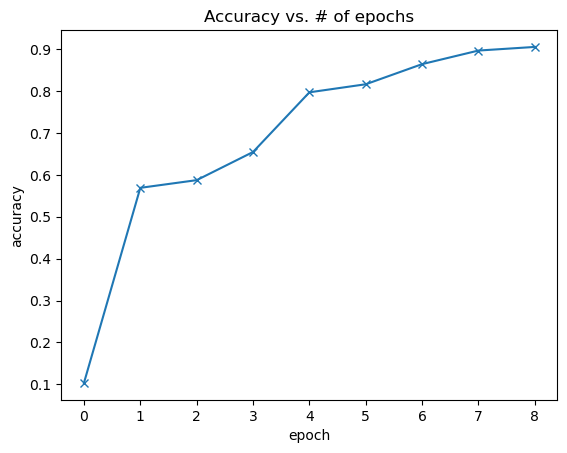

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. # of epochs')

plot_accuracies(history)


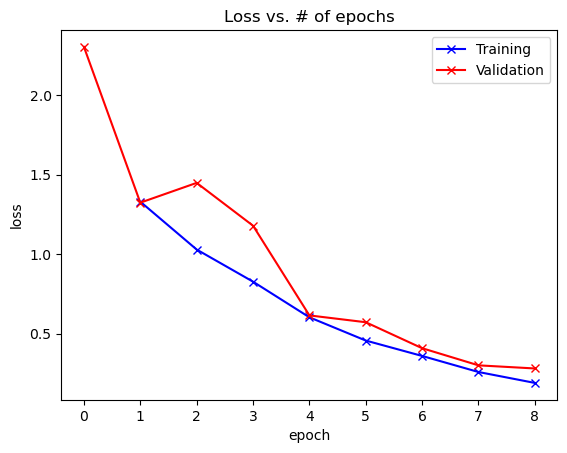

In [27]:
def plot_losses(history): 
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]                   
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. # of epochs')

plot_losses(history)

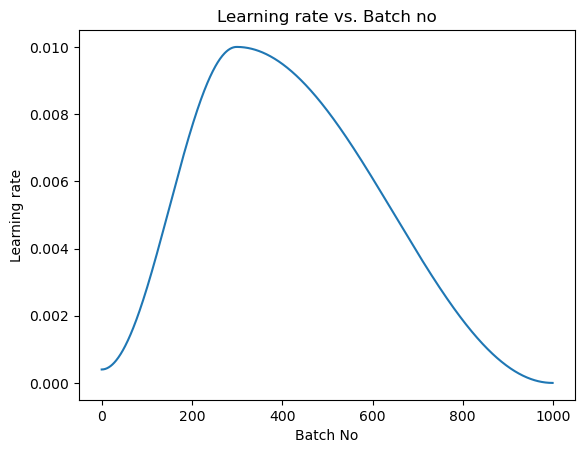

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch No')
    plt.ylabel('Learning rate')
    plt.title('Learning rate vs. Batch no')

plot_lrs(history)